# ydhV: Looking for Cys-homologs

We have two homology datasets: one generated from running MMSeqs2 against all of GTDB, and one generated by using NCBI BLAST against all sequences in the Gammaproteobacteria class. I'll start by looking at the MMSeqs2 data, as the number of matches was much larger. I will also focus on the ydhV gene, as it was longer and has more hits. 

In [1]:
from homology import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load in the query sequences from the query.fasta file. These sequences have been extended past the STOP codon. 
ydhv_seq = load_sequence_from_database('ydhV')
ydhv_seq_non_extended = ydhv_seq.split('U')[0]
ydhv_u_pos = ydhv_seq.index('U') # Get the position of the putative selenocysteine.

In [3]:
mmseqs_data = load_mmseqs()
mmseqs_data = mmseqs_data[mmseqs_data.query_gene_id == 'ydhV']
print('Number of MMSeqs2 hits for ydhV:', len(mmseqs_data))
print('Number of unique hits for ydhV', len(set(mmseqs_data.target_gene_id)))

Number of MMSeqs2 hits for ydhV: 9600
Number of unique hits for ydhV 9600


I was curious about the length distribution of the target sequence hits. I decided to plot this to inform whether or not I should filter the hits by length somehow. Based on the results in the figure, I think it is unlikely that there would be a useful match for a hit which is less than the length of the non-extended sequence. So, I decided to remove those from consideration. I think it's unlikely that any of the sequences shorter than the extended protein will also be a useful match, but the more lenient filter might be best out of caution. 

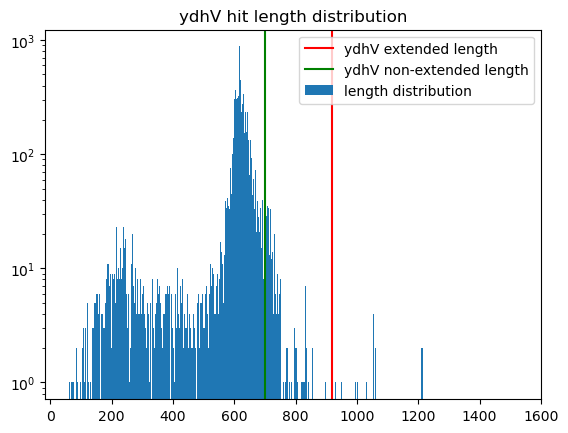

In [4]:
mmseqs_hit_lengths = mmseqs_data.target_seq.apply(len).values

fig, ax = plt.subplots(1)
ax.hist(mmseqs_hit_lengths, bins=600)
ax.set_title(f'ydhV hit length distribution')
ax.axvline(len(ydhv_seq), c='red')
ax.axvline(len(ydhv_seq_non_extended), c='green')
ax.legend([ 'ydhV extended length', 'ydhV non-extended length', 'length distribution'])
ax.set_yscale('log')
plt.show()

In [5]:
# Filter the mmseqs_data by length, keeping only the hits with a length which exceeds the length of the non-extended protein. 
mmseqs_data = mmseqs_data[mmseqs_data.target_seq.apply(len) >= (len(ydhv_seq_non_extended))]
print('Number of MMSeqs2 hits for ydhV for which the length is greater than the non-extended ydhV:', len(mmseqs_data))
# Because I am curious...
print('Number of MMSeqs2 hits for ydhV for which the length is greater than the extended ydhV:', len(mmseqs_data[mmseqs_data.target_seq.apply(len) >= (len(ydhv_seq))]))

Number of MMSeqs2 hits for ydhV for which the length is greater than the non-extended ydhV: 574
Number of MMSeqs2 hits for ydhV for which the length is greater than the extended ydhV: 30


In [6]:
# Generate pairwise alignments for each of the candidates.
get_pairwise_alignments(mmseqs_data, filename='mmseqs_alignments_ydhv.csv')

homology.get_pairwise_alignments: Reduced number of alignments from 5671678320 to 1000.
homology.get_pairwise_alignments: Reduced number of alignments from 22686713280 to 1000.
homology.get_pairwise_alignments: Reduced number of alignments from 21149944344 to 1000.
homology.get_pairwise_alignments: Reduced number of alignments from 28693548 to 1000.
homology.get_pairwise_alignments: Reduced number of alignments from 774725796 to 1000.
homology.get_pairwise_alignments: Reduced number of alignments from 834126754229645760 to 1000.
homology.get_pairwise_alignments: Reduced number of alignments from 8687979972 to 1000.
homology.get_pairwise_alignments: Reduced number of alignments from 1890559440 to 1000.
homology.get_pairwise_alignments: Unable to generate alignments for 566 target genes.


Ok, so it seems as though the pairwise alignment could not compute alignments for most of the targets (and even more were truncated). I am not sure if this is a fault of `BioPython`, or if it's just due to the fact that the alignments aren't good. The alignments have been written to `mmseqs_alignments_ydhv.csv`, so it's worth looking in to the sequences for which alignments *were* produced. 

In [10]:
mmseqs_alignments = load_alignments(filename='mmseqs_alignments_ydhv.csv')
print('Number of alignments generated for ydhV:', len(mmseqs_alignments))
target_gene_ids_with_alignments = set(mmseqs_alignments.target_gene_id)
print('Genes for which alignments were generated:', ', '.join(target_gene_ids_with_alignments))


Number of alignments generated for ydhV: 8000
Genes for which alignments were generated: NZ_LFHY01000017.1_135, NZ_CABVLQ010000001.1_711, NZ_RHJI01000012.1_48, NZ_BBMY01000121.1_14, NZ_JAATUR010000015.1_17, NZ_PTRE01000011.1_8, NZ_CP040443.1_4450, NZ_CP033092.2_2213


In [16]:
for target_gene_id in target_gene_ids_with_alignments:
    length = mmseqs_alignments[mmseqs_alignments.target_gene_id == target_gene_id].target_seq_length.iloc[0]
    print(f'Length of {target_gene_id}:', length)
print('\nLength of extended ydhV:', len(ydhv_seq))
print('Length of non-extended ydhV:', len(ydhv_seq_non_extended))

Length of NZ_LFHY01000017.1_135: 701
Length of NZ_CABVLQ010000001.1_711: 701
Length of NZ_RHJI01000012.1_48: 701
Length of NZ_BBMY01000121.1_14: 701
Length of NZ_JAATUR010000015.1_17: 701
Length of NZ_PTRE01000011.1_8: 701
Length of NZ_CP040443.1_4450: 701
Length of NZ_CP033092.2_2213: 701

Length of extended ydhV: 917
Length of non-extended ydhV: 700


I am starting to think that the BioPython approach might not be great. Planning to attempt multi-sequence alignment. 